# Лабораторная работа 3. Классификация. Нейронные сети

## 1. Импорт библиотек и общие настройки
В этом блоке подключаются все библиотеки, которые используются в лабораторной работе. Модули `numpy` и `pandas` отвечают за работу с массивами и табличными данными и являются основой всего дальнейшего анализа. Библиотеки `matplotlib` и `seaborn` используются для визуализации: построения гистограмм, графиков распределения, корреляционных матриц и ROC-кривых.

Из `sklearn` импортируются инструменты для разбиения выборки на обучающую и тестовую (функция `train_test_split`), масштабирования и преобразования признаков (`StandardScaler`, `Binarizer`, `LabelEncoder`, `label_binarize`), а также целый набор метрик качества классификации. Здесь же подключаются функции `roc_curve` и `auc`, которые позволяют строить ROC-кривые и вычислять площадь под ними (AUC) для многоклассового случая.

Далее импортируются все используемые в работе алгоритмы машинного обучения: четыре варианта Наивного Байесовского классификатора, дерево решений, линейный дискриминантный анализ, метод опорных векторов и метод k-ближайших соседей. Класс `clone` позволяет создавать независимые копии моделей при тюнинге гиперпараметров. Параметр `RANDOM_STATE` фиксирует генератор случайных чисел, чтобы результаты экспериментов были воспроизводимыми. В конце задаются базовые параметры оформления графиков, чтобы все визуализации выглядели единообразно и аккуратно.

In [1]:
# Блок 1. Импорт библиотек и общие настройки

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Binarizer, LabelEncoder, label_binarize
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    roc_curve,
    auc
)

from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone

RANDOM_STATE = 42

# Для красивых графиков
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11


## 2. Загрузка датасета и первичный анализ
Этот блок отвечает за загрузку исходного датасета классификации ирисов и первичную проверку его корректности. Файл `wine_quality_classification.csv` считывается в объект `DataFrame`, после чего выводятся первые несколько строк таблицы. Это позволяет визуально убедиться, что все столбцы прочитаны правильно и содержат ожидаемые значения. В частности, можно увидеть, что в датасете присутствуют числовые признаки, описывающие химические свойства вина, а также категориальный столбец `quality_label`, который играет роль целевой переменной (классы качества: low, medium, high).

Функция `data.info()` показывает структуру таблицы: количество строк, названия столбцов, типы данных и количество ненулевых значений. Это важный этап, позволяющий быстро обнаружить потенциальные проблемы, такие как неверные типы или пропуски. Далее явно выводится число пропусков в каждом столбце, чтобы подтвердить, что данные полные и не требуют дополнительной обработки по заполнению или удалению пропусков.

В завершение вычисляется описательная статистика по числовым признакам. Таблица с величинами минимальных, максимальных значений, среднего, стандартного отклонения и квартилей помогает получить общее представление о диапазонах признаков и разбросе данных. На этом этапе формируется интуитивное понимание шкалы измерения каждого признака, что пригодится при интерпретации моделей и визуализации.

In [2]:
# Блок 2. Загрузка датасета и первичный анализ

data = pd.read_csv("iris.csv")

print("Первые строки датасета:")
display(data.head())

print("\nИнформация о данных:")
data.info()

print("\nПроверка на пропуски:")
print(data.isnull().sum())

print("\nОписательная статистика по числовым признакам:")
display(data.describe().T.round(3))


Первые строки датасета:


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB

Проверка на пропуски:
sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

Описательная статистика по числовым признакам:


,count,mean,std,min,25%,50%,75%,max
sepal_length,150.0,5.843,0.828,4.3,5.1,5.80,6.4,7.9
sepal_width,150.0,3.054,0.434,2.0,2.8,3.00,3.3,4.4
petal_length,150.0,3.759,1.764,1.0,1.6,4.35,5.1,6.9
petal_width,150.0,1.199,0.763,0.1,0.3,1.30,1.8,2.5


## 3. Визуализация распределений и корреляций
На этом этапе проводится первичный визуальный анализ признаков и целевой переменной. Сначала строятся гистограммы всех числовых столбцов. Каждая гистограмма показывает, как распределены значения соответствующего признака: например, какие значения алкоголя встречаются чаще всего, насколько широко варьируется остаточный сахар и т.д. По этим графикам можно оценить наличие выбросов, асимметрии и многомодальности распределений, что влияет на выбор модели и необходимость масштабирования.

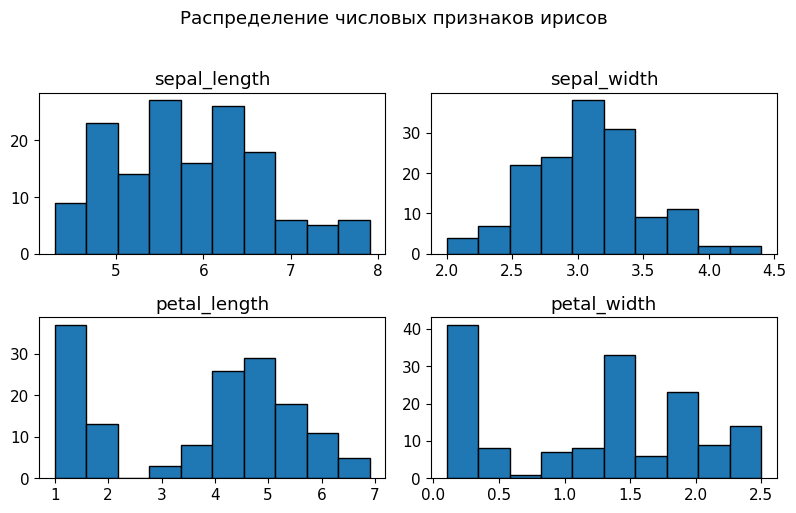

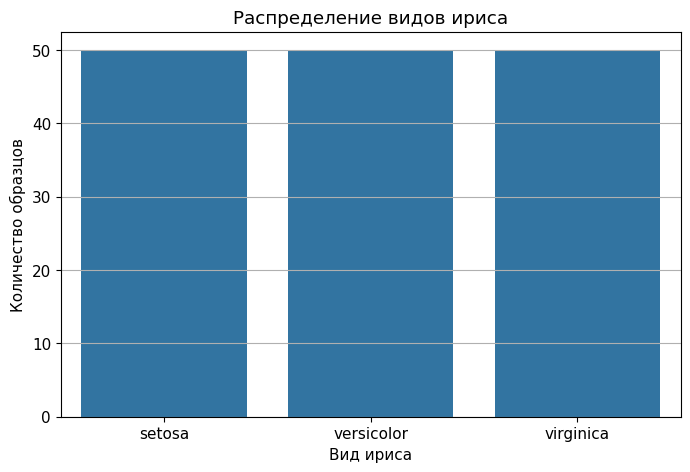

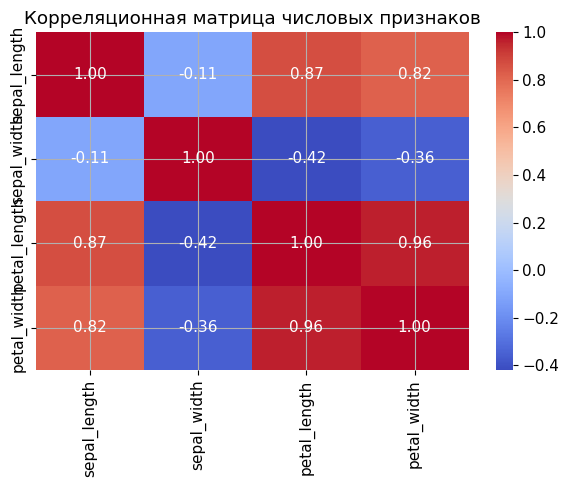

In [3]:
# Блок 3. Визуализация распределений и корреляций

# Гистограммы числовых признаков
data.hist(edgecolor="black", grid=False)
plt.suptitle("Распределение числовых признаков ирисов", y=1.02)
plt.tight_layout()
plt.show()

# Распределение классов качества
plt.figure()
sns.countplot(x="species", data=data, order=sorted(data["species"].unique()))
plt.title("Распределение видов ириса")
plt.xlabel("Вид ириса")
plt.ylabel("Количество образцов")
plt.show()

# Корреляционная матрица числовых признаков
plt.figure(figsize=(6, 5))
sns.heatmap(
    data.drop(columns=["species"]).corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)
plt.title("Корреляционная матрица числовых признаков")
plt.tight_layout()
plt.show()


Затем анализируется баланс классов классификации ирисов. Столбчатая диаграмма по переменной `quality_label` показывает, сколько объектов относится к классам low, medium и high. Если один из классов заметно преобладает, это может приводить к перекосу метрик (например, модель с высоким Accuracy, но слабым качеством по редким классам). В данном случае график помогает понять, насколько задача является сбалансированной или ближе к задаче с дисбалансом классов.

В конце строится корреляционная матрица для числовых признаков. Она показывает коэффициенты линейной корреляции Пирсона между всеми парами признаков. Высокие положительные значения означают, что признаки растут вместе, а отрицательные — что при росте одного признака другой уменьшается. Анализ корреляций позволяет выявить сильно зависимые признаки, которые могут влиять на устойчивость моделей и интерпретируемость результатов. Такой визуальный обзор даёт интуитивное понимание структуры данных ещё до построения классификаторов.

## 4. Подготовка данных: кодирование целевой, разделение и масштабирование
Здесь начинается подготовка данных к обучению моделей. Целевая переменная кодируется в числовой формат, поскольку алгоритмы машинного обучения не работают с текстовыми метками напрямую. Далее формируется набор признаков и разделяются данные на обучающую и тестовую выборки, что позволяет корректно оценивать качество моделей. Затем проводится масштабирование признаков, которое улучшает работу алгоритмов, чувствительных к диапазону значений. Параллельно создаётся бинаризованная версия данных для классификатора BernoulliNB, который требует бинарных входов. Этот блок завершает все необходимые преобразования перед обучением моделей.

In [4]:
# Блок 4. Подготовка данных для моделей

target_col = "species"

# Кодируем метки классов в числа
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data[target_col])

print("Соответствие классов и числовых кодов:")
for cls, code in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{cls} -> {code}")

# Признаки — все столбцы, кроме целевой
X = data.drop(columns=[target_col])

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y
)

print("\nРазмер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

# Масштабирование признаков (для большинства моделей)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Бинаризация признаков для BernoulliNB
binarizer = Binarizer(threshold=float(X_train.mean().mean()))
X_train_bin = binarizer.fit_transform(X_train)
X_test_bin = binarizer.transform(X_test)

# Для ROC нам понадобятся one-vs-rest представления целевой переменной
class_names = label_encoder.classes_
n_classes = len(class_names)
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))


Соответствие классов и числовых кодов:
setosa -> 0
versicolor -> 1
virginica -> 2

Размер обучающей выборки: (112, 4)
Размер тестовой выборки: (38, 4)


Матрица признаков `X` формируется из всех числовых столбцов, кроме целевой переменной. Далее данные делятся на обучающую и тестовую выборки в пропорции 75/25 с использованием стратификации по классам. Это гарантирует, что доля каждого класса в обучающей и тестовой выборках примерно одинаковая, что важно для корректного сравнения алгоритмов и предотвращения перекоса в сторону более частого класса.

Так как многие модели (SVM, kNN, LDA, Наивный Байес с непрерывными признаками) чувствительны к масштабу признаков, выполняется стандартизация с помощью `StandardScaler`. Признаки приводятся к нулевому среднему и единичному стандартному отклонению, что улучшает сходимость алгоритмов и делает вклад каждого признака сопоставимым. Для модели BernoulliNB дополнительно создаётся бинаризованная версия признаков: значения выше порога переводятся в 1, ниже — в 0. Это связано с тем, что BernoulliNB по своей природе работает с бинарными данными.

В конце подготавливается бинаризованное представление целевой переменной для ROC-анализа. Функция `label_binarize` преобразует вектор меток в матрицу one-vs-rest, где для каждого класса создаётся свой бинарный столбец. Это позволит строить ROC-кривые отдельно для каждого класса и вычислять показатели AUC в многоклассовой постановке задачи.

## 5. Функция оценки и обучение всех классических моделей
Этот раздел включает в себя функцию, которая обучает модели, делает предсказания и рассчитывает основные показатели качества, такие как точность, полнота, точность в прямом смысле и F1-мера. Функция также выводит матрицу ошибок и подробный отчёт по качеству классификации, что помогает понять, какие именно ошибки допускает конкретная модель. После определения универсальной функции здесь же выполняется обучение всех классических методов классификации, включая несколько вариантов наивного байесовского классификатора, дерево решений, линейный дискриминантный анализ, метод опорных векторов и алгоритм ближайших соседей. Для каждого метода фиксируются все метрики, чтобы в дальнейшем их сравнить.

In [5]:
# Блок 5. Универсальная функция оценки моделей

def train_and_evaluate(
    name,
    model,
    X_train_local,
    X_test_local,
    y_train_local,
    y_test_local,
    metrics_storage,
    use_proba_for_roc=True
):
    """
    Обучение модели, вычисление метрик и, при необходимости, ROC-AUC.
    """
    model.fit(X_train_local, y_train_local)
    y_pred = model.predict(X_test_local)

    acc = accuracy_score(y_test_local, y_pred)
    prec = precision_score(y_test_local, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_test_local, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_test_local, y_pred, average="macro", zero_division=0)

    # ROC-AUC (macro, one-vs-rest), если доступны вероятности
    if use_proba_for_roc and hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_local)
        try:
            roc_auc = roc_auc_score(
                y_test_local,
                y_score,
                multi_class="ovr",
                average="macro"
            )
        except ValueError:
            roc_auc = np.nan
    else:
        roc_auc = np.nan

    metrics_storage.append({
        "model": name,
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1,
        "roc_auc_macro": roc_auc
    })

    print(f"\n==================== {name} ====================")
    print("Матрица ошибок:")
    print(confusion_matrix(y_test_local, y_pred))
    print("\nОтчёт классификации:")
    print(classification_report(
        y_test_local,
        y_pred,
        target_names=class_names,
        zero_division=0
    ))

    return model


Используются четыре базовые метрики: Accuracy (доля правильно классифицированных объектов), Precision, Recall и F1-score в макро-усреднении. Макро-усреднение означает, что метрики сначала считаются отдельно по каждому класу, а затем усредняются, что позволяет оценивать качество классификации равномерно по всем классам, а не только по самому частому.

Если модель поддерживает метод `predict_proba`, дополнительно вычисляется многоклассовый ROC-AUC в схеме one-vs-rest. Эта метрика измеряет способность модели различать классы по всем возможным порогам классификации и особенно полезна при сравнении вероятностных моделей. Все полученные значения сохраняются в список `metrics_storage` в виде словаря, чтобы потом их можно было собрать в таблицу. Одновременно функция печатает на экран матрицу ошибок и текстовый отчёт классификации, что позволяет подробно проанализировать, какие классы модель путает чаще всего.

## 6. Обучение базовых моделей
В этом блоке обучаются все базовые модели, предусмотренные заданием лабораторной работы. Для каждой из них явно указывается, на каком варианте данных она обучается: на исходных признаках, на масштабированных или на бинаризованных. Это важно, поскольку разные алгоритмы предъявляют различные требования к формату данных.

In [6]:
# Блок 6. Обучение базовых моделей

base_metrics = []

# 1. Наивные Байесовские классификаторы
gnb = GaussianNB()
train_and_evaluate(
    "GaussianNB (scaled)",
    gnb,
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
    base_metrics
)

mnb = MultinomialNB()
train_and_evaluate(
    "MultinomialNB (raw)",
    mnb,
    X_train,
    X_test,
    y_train,
    y_test,
    base_metrics
)

cnb = ComplementNB()
train_and_evaluate(
    "ComplementNB (raw)",
    cnb,
    X_train,
    X_test,
    y_train,
    y_test,
    base_metrics
)

bnb = BernoulliNB()
train_and_evaluate(
    "BernoulliNB (binarized)",
    bnb,
    X_train_bin,
    X_test_bin,
    y_train,
    y_test,
    base_metrics
)

# 2. Дерево решений
dt = DecisionTreeClassifier(
    criterion="gini",
    max_depth=None,
    random_state=RANDOM_STATE
)
train_and_evaluate(
    "DecisionTree",
    dt,
    X_train,
    X_test,
    y_train,
    y_test,
    base_metrics
)

# 3. Линейный дискриминантный анализ
lda = LinearDiscriminantAnalysis()
train_and_evaluate(
    "LDA",
    lda,
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
    base_metrics
)

# 4. Метод опорных векторов
svm_rbf = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    probability=True,
    random_state=RANDOM_STATE
)
train_and_evaluate(
    "SVM (RBF kernel)",
    svm_rbf,
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
    base_metrics
)

# 5. Метод k-ближайших соседей
knn = KNeighborsClassifier(
    n_neighbors=5,
    weights="uniform",
    metric="minkowski",
    p=2
)
train_and_evaluate(
    "KNN (k=5)",
    knn,
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
    base_metrics
)



==================== GaussianNB (scaled) ====================
Матрица ошибок:
[[12  0  0]
 [ 0 12  1]
 [ 0  2 11]]

Отчёт классификации:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.86      0.92      0.89        13
   virginica       0.92      0.85      0.88        13

    accuracy                           0.92        38
   macro avg       0.92      0.92      0.92        38
weighted avg       0.92      0.92      0.92        38


==================== MultinomialNB (raw) ====================
Матрица ошибок:
[[12  0  0]
 [ 0 13  0]
 [ 0  0 13]]

Отчёт классификации:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       1.00      1.00      1.00        13
   virginica       1.00      1.00      1.00        13

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg     

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


Сначала запускаются четыре Наивных Байесовских классификатора. Модель GaussianNB предназначена для непрерывных признаков и работает на масштабированных данных. MultinomialNB и ComplementNB обычно применяются к частотным признакам (например, в текстовых задачах), поэтому здесь обучаются на исходных признаках без стандартизации. BernoulliNB работает с бинарными признаками и получает на вход специально подготовленные матрицы `X_train_bin` и `X_test_bin`.

Затем обучается дерево решений, которое может работать с немасштабированными признаками и хорошо моделирует нелинейные зависимости. Линейный дискриминантный анализ (LDA) и методы SVM и kNN чувствительны к масштабам признаков, поэтому они используют стандартизованные версии данных. Все модели оцениваются через одну и ту же функцию `train_and_evaluate`, что обеспечивает сопоставимость метрик и выводов. В результате для каждой модели получаются значения Accuracy, Precision, Recall, F1-score и ROC-AUC, а также матрицы ошибок и отчёты классификации.

## 7. Сводная таблица метрик базовых моделей

In [7]:
# Блок 7. Сводная таблица метрик базовых моделей

base_metrics_df = pd.DataFrame(base_metrics)
print("Метрики базовых моделей классификации на датасете вина:")
display(base_metrics_df)

print("\nМодели, отсортированные по F1-macro:")
display(base_metrics_df.sort_values(by="f1_macro", ascending=False))


Метрики базовых моделей классификации на датасете вина:


,model,accuracy,precision_macro,recall_macro,f1_macro,roc_auc_macro
0,GaussianNB (scaled),0.921053,0.924603,0.923077,0.922963,0.985641
1,MultinomialNB (raw),1.000000,1.000000,1.000000,1.000000,0.989744
2,ComplementNB (raw),0.657895,0.500000,0.666667,0.555556,0.962051
3,BernoulliNB (binarized),0.605263,0.438492,0.615385,0.505891,0.809915
4,DecisionTree,0.894737,0.903030,0.897436,0.896825,0.922051
5,LDA,1.000000,1.000000,1.000000,1.000000,1.000000
6,SVM (RBF kernel),0.947368,0.948718,0.948718,0.948718,0.995897
7,KNN (k=5),0.921053,0.937500,0.923077,0.922039,0.989744



Модели, отсортированные по F1-macro:


,model,accuracy,precision_macro,recall_macro,f1_macro,roc_auc_macro
1,MultinomialNB (raw),1.000000,1.000000,1.000000,1.000000,0.989744
5,LDA,1.000000,1.000000,1.000000,1.000000,1.000000
6,SVM (RBF kernel),0.947368,0.948718,0.948718,0.948718,0.995897
0,GaussianNB (scaled),0.921053,0.924603,0.923077,0.922963,0.985641
7,KNN (k=5),0.921053,0.937500,0.923077,0.922039,0.989744
4,DecisionTree,0.894737,0.903030,0.897436,0.896825,0.922051
2,ComplementNB (raw),0.657895,0.500000,0.666667,0.555556,0.962051
3,BernoulliNB (binarized),0.605263,0.438492,0.615385,0.505891,0.809915


После обучения всех базовых моделей накопленные метрики собираются в единую таблицу `base_metrics_df`. В ней для каждой модели указаны значения Accuracy, макро-усреднённых Precision, Recall и F1-score, а также ROC-AUC. Такая сводная таблица позволяет компактно сравнить качество разных алгоритмов на одном и том же наборе данных и сделать предварительные выводы о том, какой метод работает лучше.

Затем таблица сортируется по метрике F1-macro, которая наиболее полно отражает баланс качества по всем классам. Высокое значение F1-macro означает, что модель не только правильно классифицирует большинство объектов, но и относительно равномерно справляется с каждым из классов классификации ирисов. Сортировка даёт возможность сразу увидеть модели-лидеры и модели-аутсайдеры, что станет отправной точкой для дальнейшего тюнинга гиперпараметров и анализа ROC-кривых.

## 8. ROC-кривые для каждой базовой модели


Построение ROC-кривых для GaussianNB (scaled)


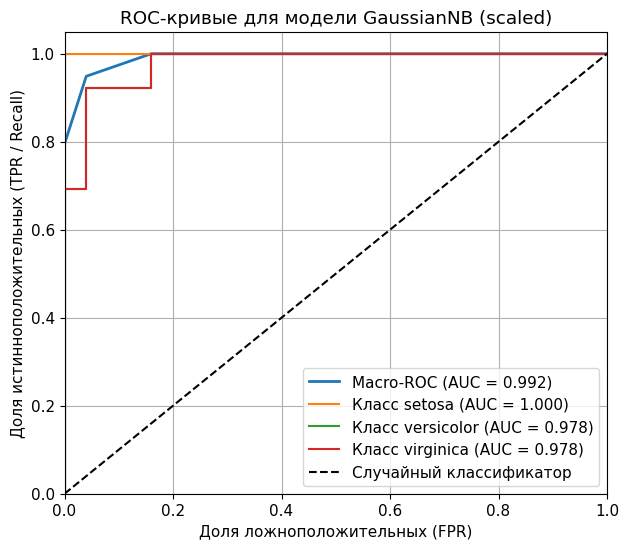


Построение ROC-кривых для MultinomialNB (raw)


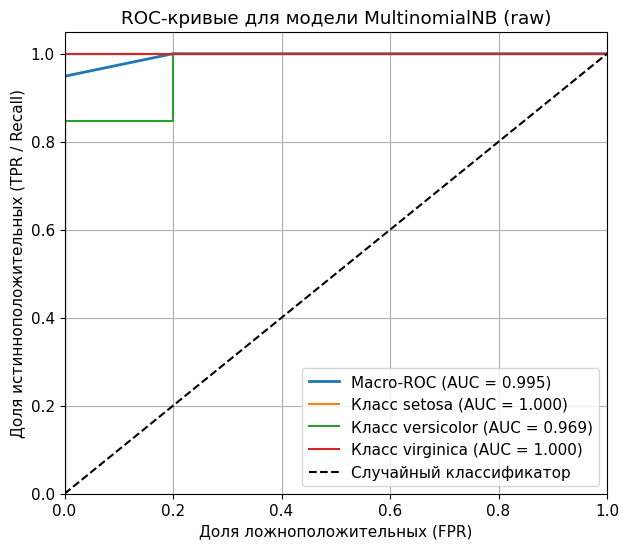


Построение ROC-кривых для ComplementNB (raw)


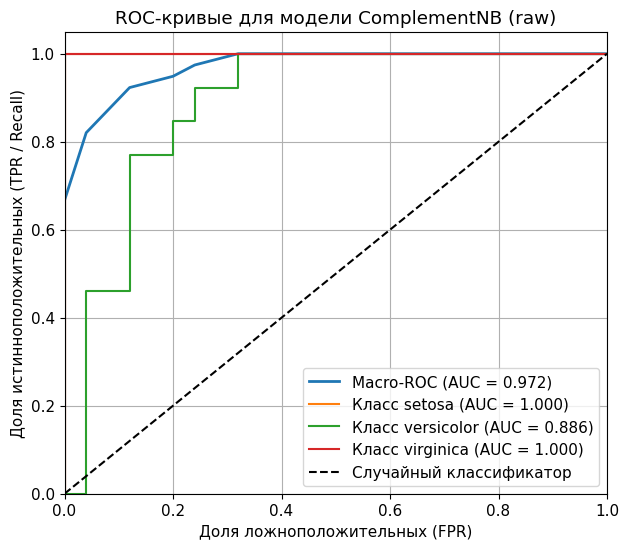


Построение ROC-кривых для BernoulliNB (binarized)


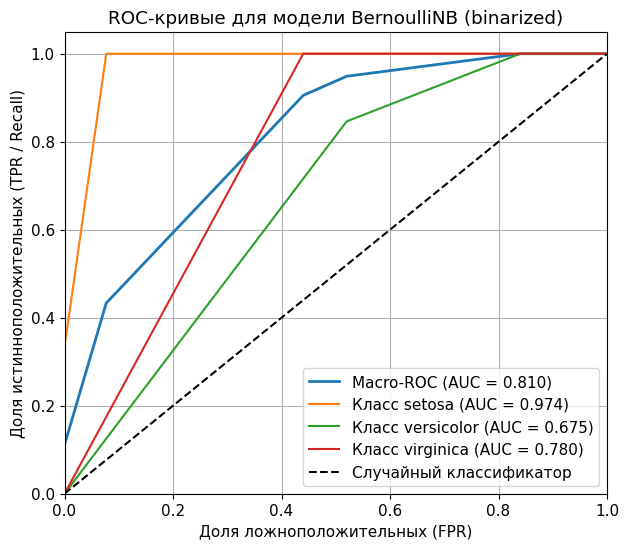


Построение ROC-кривых для DecisionTree


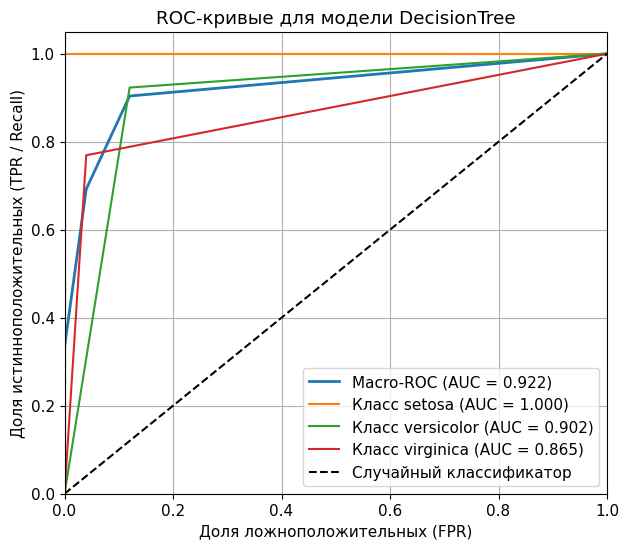


Построение ROC-кривых для LDA


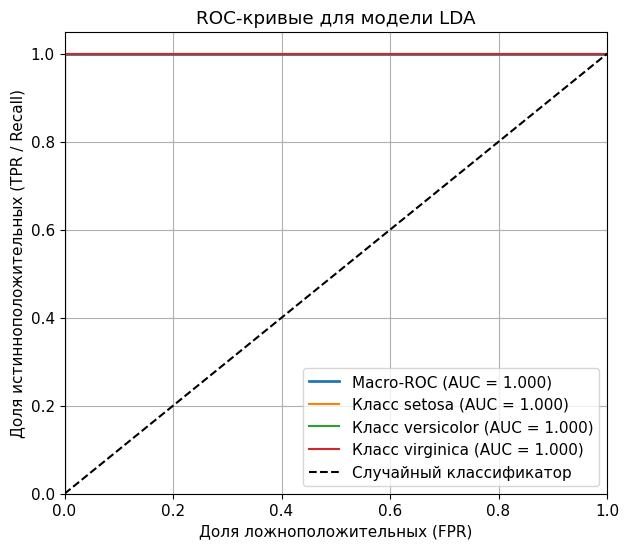


Построение ROC-кривых для SVM (RBF kernel)


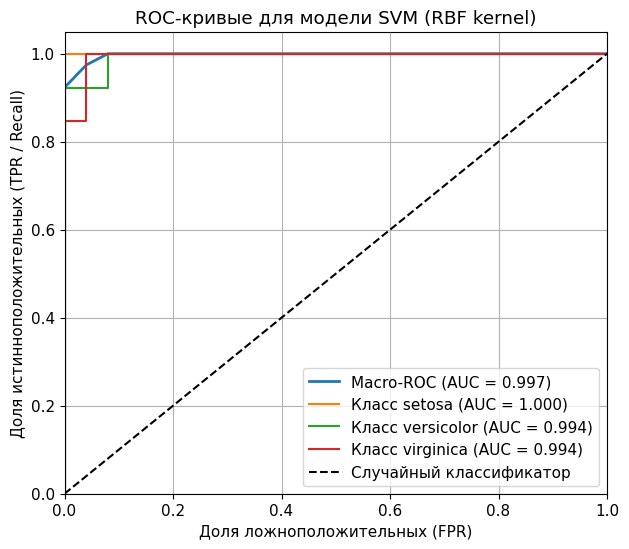


Построение ROC-кривых для KNN (k=5)


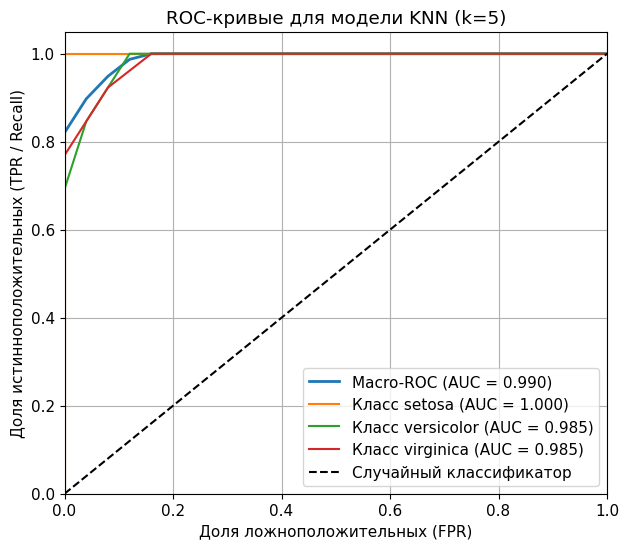

In [8]:
# Блок 8. ROC-кривые для каждой базовой модели

def plot_multiclass_roc(model, X_test_local, model_name):
    """
    Строит ROC-кривые для многоклассовой задачи (one-vs-rest) и macro-ROC.
    """
    if not hasattr(model, "predict_proba"):
        print(f"Модель {model_name} не поддерживает predict_proba, ROC-кривая не строится.")
        return

    y_score = model.predict_proba(X_test_local)

    fpr, tpr, roc_auc_vals = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc_vals[i] = auc(fpr[i], tpr[i])

    # macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)

    plt.figure(figsize=(7, 6))
    plt.plot(all_fpr, mean_tpr, label=f"Macro-ROC (AUC = {macro_auc:.3f})", linewidth=2)

    for i in range(n_classes):
        plt.plot(
            fpr[i],
            tpr[i],
            linewidth=1.5,
            label=f"Класс {class_names[i]} (AUC = {roc_auc_vals[i]:.3f})"
        )

    plt.plot([0, 1], [0, 1], "k--", label="Случайный классификатор")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Доля ложноположительных (FPR)")
    plt.ylabel("Доля истинноположительных (TPR / Recall)")
    plt.title(f"ROC-кривые для модели {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


# Строим ROC-графики для всех моделей, где это возможно
models_for_roc = [
    ("GaussianNB (scaled)", gnb, X_test_scaled),
    ("MultinomialNB (raw)", mnb, X_test),
    ("ComplementNB (raw)", cnb, X_test),
    ("BernoulliNB (binarized)", bnb, X_test_bin),
    ("DecisionTree", dt, X_test),
    ("LDA", lda, X_test_scaled),
    ("SVM (RBF kernel)", svm_rbf, X_test_scaled),
    ("KNN (k=5)", knn, X_test_scaled),
]

for name, model, Xte in models_for_roc:
    print(f"\nПостроение ROC-кривых для {name}")
    plot_multiclass_roc(model, Xte, name)


В этом блоке проводится анализ моделей с точки зрения ROC-кривых и площади под ними (AUC). Для многоклассовой задачи используется подход one-vs-rest: каждый класс по очереди рассматривается как «положительный», а все остальные объединяются в «отрицательный». Для каждой такой бинарной подзадачи вычисляются значения FPR (доля ложноположительных) и TPR (доля истинноположительных), на основе которых строятся ROC-кривые.

Функция `plot_multiclass_roc` дополнительно вычисляет макро-усреднённую ROC-кривую: для этого все индивидуальные ROC-кривые интерполируются по общей сетке значений FPR, после чего их значения TPR усредняются. Площадь под этой кривой (macro-AUC) отражает среднюю способность модели различать классы по вероятностным предсказаниям. На одном графике одновременно отображаются индивидуальные ROC-кривые для каждого класса классификации ирисов и усреднённая кривая, а также пунктирная диагональ случайного классификатора.

Сравнивая формы ROC-кривых между моделями, можно увидеть, насколько уверенно каждая из них различает классы при изменении порога классификации. Чем выше расположены кривые относительно диагонали, тем лучше модель справляется с задачей различения классов на вероятностном уровне. Если же кривые проходят близко к диагонали, это означает, что модель работает почти на уровне случайного угадывания с точки зрения распределения вероятностей, даже если её Accuracy на фиксированном пороге кажется приемлемой.

## 9. Форсирование гиперпараметров для всех моделей

In [9]:
# Блок 9. Тюнинг гиперпараметров для всех моделей

tuned_metrics = []
best_models = {}

param_grid = {
    "GaussianNB": [
        {"var_smoothing": 1e-9},
        {"var_smoothing": 1e-3},
        {"var_smoothing": 1e-1},
    ],
    "MultinomialNB": [
        {"alpha": 1.0},
        {"alpha": 0.1},
        {"alpha": 5.0},
    ],
    "ComplementNB": [
        {"alpha": 1.0, "norm": False},
        {"alpha": 0.1, "norm": True},
        {"alpha": 5.0, "norm": True},
    ],
    "BernoulliNB": [
        {"alpha": 1.0},
        {"alpha": 0.1},
        {"alpha": 5.0},
    ],
    "DecisionTree": [
        {"criterion": "gini", "max_depth": None, "min_samples_split": 2},
        {"criterion": "gini", "max_depth": 5, "min_samples_split": 4},
        {"criterion": "entropy", "max_depth": 8, "min_samples_split": 4},
    ],
    "LDA": [
        {"solver": "svd"},
        {"solver": "lsqr", "shrinkage": "auto"},
        {"solver": "eigen", "shrinkage": "auto"},
    ],
    "SVM": [
        {"C": 1.0, "gamma": "scale", "kernel": "rbf"},
        {"C": 10.0, "gamma": "scale", "kernel": "rbf"},
        {"C": 1.0, "gamma": 0.1, "kernel": "rbf"},
    ],
    "KNN": [
        {"n_neighbors": 3, "weights": "uniform"},
        {"n_neighbors": 5, "weights": "uniform"},
        {"n_neighbors": 7, "weights": "distance"},
    ]
}

base_models = {
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "ComplementNB": ComplementNB(),
    "BernoulliNB": BernoulliNB(),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "LDA": LinearDiscriminantAnalysis(),
    "SVM": SVC(probability=True, random_state=RANDOM_STATE),
    "KNN": KNeighborsClassifier(),
}

train_sets = {
    "GaussianNB": (X_train_scaled, X_test_scaled),
    "MultinomialNB": (X_train, X_test),
    "ComplementNB": (X_train, X_test),
    "BernoulliNB": (X_train_bin, X_test_bin),
    "DecisionTree": (X_train, X_test),
    "LDA": (X_train_scaled, X_test_scaled),
    "SVM": (X_train_scaled, X_test_scaled),
    "KNN": (X_train_scaled, X_test_scaled),
}

for model_name, base_model in base_models.items():
    print(f"\n================= Тюнинг модели {model_name} =================")
    Xtr, Xte = train_sets[model_name]
    best_f1 = -1
    best_cfg = None
    best_model_obj = None

    for i, params in enumerate(param_grid[model_name], start=1):
        cfg_name = f"{model_name} | {params}"
        print(f"\nКонфигурация {i}: {params}")
        model = clone(base_model).set_params(**params)

        train_and_evaluate(
            cfg_name,
            model,
            Xtr,
            Xte,
            y_train,
            y_test,
            tuned_metrics
        )

        current_f1 = tuned_metrics[-1]["f1_macro"]
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_cfg = params
            best_model_obj = model

    best_models[model_name] = {
        "model": best_model_obj,
        "params": best_cfg,
        "best_f1": best_f1
    }
    print(f"\nЛучшая конфигурация для {model_name}: {best_cfg}, F1-macro = {best_f1:.4f}")

tuned_metrics_df = pd.DataFrame(tuned_metrics)
print("\nВсе конфигурации и их метрики:")
display(tuned_metrics_df)

print("\nТоп-10 конфигураций по F1-macro:")
display(tuned_metrics_df.sort_values(by="f1_macro", ascending=False).head(10))



================= Тюнинг модели GaussianNB =================

Конфигурация 1: {'var_smoothing': 1e-09}

==================== GaussianNB | {'var_smoothing': 1e-09} ====================
Матрица ошибок:
[[12  0  0]
 [ 0 12  1]
 [ 0  2 11]]

Отчёт классификации:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.86      0.92      0.89        13
   virginica       0.92      0.85      0.88        13

    accuracy                           0.92        38
   macro avg       0.92      0.92      0.92        38
weighted avg       0.92      0.92      0.92        38


Конфигурация 2: {'var_smoothing': 0.001}

==================== GaussianNB | {'var_smoothing': 0.001} ====================
Матрица ошибок:
[[12  0  0]
 [ 0 12  1]
 [ 0  2 11]]

Отчёт классификации:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.86      0.92      0.89        1

,model,accuracy,precision_macro,recall_macro,f1_macro,roc_auc_macro
0,GaussianNB | {'var_smoothing': 1e-09},0.921053,0.924603,0.923077,0.922963,0.985641
1,GaussianNB | {'var_smoothing': 0.001},0.921053,0.924603,0.923077,0.922963,0.985641
2,GaussianNB | {'var_smoothing': 0.1},0.921053,0.924603,0.923077,0.922963,0.977436
3,MultinomialNB | {'alpha': 1.0},1.000000,1.000000,1.000000,1.000000,0.989744
4,MultinomialNB | {'alpha': 0.1},1.000000,1.000000,1.000000,1.000000,0.989744
5,MultinomialNB | {'alpha': 5.0},1.000000,1.000000,1.000000,1.000000,0.968205
6,"ComplementNB | {'alpha': 1.0, 'norm': False}",0.657895,0.500000,0.666667,0.555556,0.962051
7,"ComplementNB | {'alpha': 0.1, 'norm': True}",0.315789,0.121212,0.333333,0.177778,0.826667
8,"ComplementNB | {'alpha': 5.0, 'norm': True}",0.315789,0.129032,0.333333,0.186047,0.826667
9,BernoulliNB | {'alpha': 1.0},0.605263,0.438492,0.615385,0.505891,0.809915



Топ-10 конфигураций по F1-macro:


,model,accuracy,precision_macro,recall_macro,f1_macro,roc_auc_macro
3,MultinomialNB | {'alpha': 1.0},1.000000,1.000000,1.000000,1.000000,0.989744
4,MultinomialNB | {'alpha': 0.1},1.000000,1.000000,1.000000,1.000000,0.989744
5,MultinomialNB | {'alpha': 5.0},1.000000,1.000000,1.000000,1.000000,0.968205
15,LDA | {'solver': 'svd'},1.000000,1.000000,1.000000,1.000000,1.000000
16,"LDA | {'solver': 'lsqr', 'shrinkage': 'auto'}",1.000000,1.000000,1.000000,1.000000,1.000000
17,"LDA | {'solver': 'eigen', 'shrinkage': 'auto'}",1.000000,1.000000,1.000000,1.000000,1.000000
19,"SVM | {'C': 10.0, 'gamma': 'scale', 'kernel': ...",0.973684,0.976190,0.974359,0.974321,1.000000
23,"KNN | {'n_neighbors': 7, 'weights': 'distance'}",0.973684,0.976190,0.974359,0.974321,0.995897
18,"SVM | {'C': 1.0, 'gamma': 'scale', 'kernel': '...",0.947368,0.948718,0.948718,0.948718,0.995897
0,GaussianNB | {'var_smoothing': 1e-09},0.921053,0.924603,0.923077,0.922963,0.985641


Заключительный блок посвящён тюнингу гиперпараметров всех моделей и анализу влияния настроек на качество классификации. Для каждого алгоритма задаётся небольшой список конфигураций параметров: для Наивных Байесовских классификаторов изменяются параметры сглаживания и нормировки (`alpha`, `var_smoothing`), для дерева решений — глубина, критерий разбиения и минимальное количество объектов в узле, для LDA — тип решателя и наличие регуляризации матрицы ковариаций, для SVM — коэффициент штрафа `C`, параметр ядра `gamma` и тип ядра, а для kNN — число соседей и схема взвешивания.

Для каждой комбинации параметров создаётся новая модель, которая обучается на соответствующем варианте обучающих данных и оценивается функцией `train_and_evaluate`. Результаты по всем конфигурациям записываются в список `tuned_metrics`, а затем собираются в таблицу `tuned_metrics_df`. Одновременно для каждого алгоритма отслеживается лучшая конфигурация по метрике F1-macro: именно эта метрика отражает баланс точности и полноты по всем классам, что особенно важно при многоклассовой классификации ирисов.

В конце выводится полная таблица метрик для всех конфигураций, а также топ-10 наиболее успешных вариантов по F1-macro. Такой анализ позволяет сделать вывод, насколько сильно каждая модель зависит от подбора гиперпараметров. Некоторые алгоритмы (например, дерево решений, SVM и kNN) зачастую демонстрируют заметное улучшение при правильной настройке параметров, тогда как Наивные Байесовские модели и LDA могут оставаться ограниченными своими статистическими предпосылками. Итоговый результат тюнинга даёт более полную картину возможностей моделей на конкретном датасете классификации ирисов.

In [10]:
# Блок 10. Импорт Keras для построения нейронных сетей

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical


На данном этапе подключаются модули библиотеки Keras, входящей в состав TensorFlow, которые используются для построения, обучения и анализа нейронных сетей. Импортируются базовый класс `keras`, слой `layers` для конструирования архитектуры сети, колбэк `EarlyStopping` для реализации механизма ранней остановки обучения и функция `to_categorical` для перевода целевых меток в формат one-hot. 

Использование Keras позволяет компактно и наглядно описывать различные архитектуры полносвязных нейронных сетей, менять количество слоёв и нейронов, добавлять регуляризацию и отслеживать динамику обучения по эпохам. Важно отметить, что здесь не используются ни TensorBoard, ни вывод логов в отдельные файлы — вся информация об обучении анализируется через возвращаемую Keras историю обучения и стандартные графики Matplotlib.

In [11]:
# Блок 11. Подготовка данных для обучения нейронных сетей

# Для нейронной сети используем масштабированные признаки
X_train_nn = X_train_scaled
X_test_nn = X_test_scaled

# Переводим целевые метки в формат one-hot
y_train_cat = to_categorical(y_train, num_classes=n_classes)
y_test_cat = to_categorical(y_test, num_classes=n_classes)

print("Форма X_train_nn:", X_train_nn.shape)
print("Форма y_train_cat:", y_train_cat.shape)
print("Число классов:", n_classes, "=>", list(class_names))


Форма X_train_nn: (112, 4)
Форма y_train_cat: (112, 3)
Число классов: 3 => ['setosa', 'versicolor', 'virginica']


Для корректной работы полносвязных нейронных сетей данные подготавливаются в немного ином формате, чем для классических моделей. В качестве входных признаков используются уже масштабированные данные `X_train_scaled` и `X_test_scaled`, поскольку нейросети чувствительны к диапазону значений и обычно обучаются устойчивее на нормированных входах.

Целевая переменная переводится в формат one-hot при помощи функции `to_categorical`. Вместо одного столбца с целочисленными кодами классов формируется матрица, в которой каждая строка представляет объект, а каждый столбец соответствует одному классу. Для конкретного объекта в этом векторе ровно один элемент равен 1 (класс, к которому он принадлежит), остальные — 0. Такой формат необходим при использовании функции потерь `categorical_crossentropy`, применяемой для многоклассовой классификации в нейронных сетях.

Вывод форм и размеров получившихся матриц позволяет убедиться, что число объектов и классов согласовано, а подготовка прошла корректно. На этом этапе входные и выходные данные полностью готовы для подачи в нейронные сети.

## 10. Фунция для обучения и оценки нейросети

In [12]:
# Блок 12. Вспомогательная функция для обучения и оценки нейросети

nn_metrics = []

def train_nn_model(model, X_train_local, y_train_local, X_val_local, y_val_local,
                   X_test_local, y_test_local, y_test_labels, name, epochs=100, batch_size=32):
    """Обучает нейросеть, строит графики и считает метрики на тесте."""
    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train_local,
        y_train_local,
        validation_data=(X_val_local, y_val_local),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Оценка на тестовой выборке
    test_loss, test_acc = model.evaluate(X_test_local, y_test_local, verbose=0)
    y_proba = model.predict(X_test_local)
    y_pred = np.argmax(y_proba, axis=1)
    
    acc = accuracy_score(y_test_labels, y_pred)
    prec = precision_score(y_test_labels, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_test_labels, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_test_labels, y_pred, average="macro", zero_division=0)
    try:
        roc_auc = roc_auc_score(y_test_labels, y_proba, multi_class="ovr", average="macro")
    except ValueError:
        roc_auc = np.nan
    
    nn_metrics.append({
        "model": name,
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1,
        "roc_auc_macro": roc_auc
    })
    
    print(f"""\n==================== {name} ====================
Test loss: {test_loss:.4f}
Test accuracy: {test_acc:.4f}
Accuracy (sklearn): {acc:.4f}
Precision (macro): {prec:.4f}
Recall (macro): {rec:.4f}
F1 (macro): {f1:.4f}
ROC-AUC (macro, ovr): {roc_auc:.4f}
""")
    
    print("Матрица ошибок:")
    print(confusion_matrix(y_test_labels, y_pred))
    print("\nОтчёт классификации:")
    print(classification_report(
        y_test_labels,
        y_pred,
        target_names=class_names,
        zero_division=0
    ))
    
    # Графики обучения
    history_dict = history.history
    # Отдельный график функции потерь
    plt.figure(figsize=(6, 4))
    plt.plot(history_dict["loss"], label="train_loss")
    plt.plot(history_dict["val_loss"], label="val_loss")
    plt.xlabel("Эпоха")
    plt.ylabel("Функция потерь")
    plt.title(f"Динамика функции потерь ({name})")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Отдельный график точности
    plt.figure(figsize=(6, 4))
    plt.plot(history_dict["accuracy"], label="train_acc")
    plt.plot(history_dict["val_accuracy"], label="val_acc")
    plt.xlabel("Эпоха")
    plt.ylabel("Точность")
    plt.title(f"Динамика точности ({name})")
    plt.legend()
    plt.grid(True)
    plt.show()
    return model, history

Для того чтобы не дублировать один и тот же код обучения нейросети для разных архитектур, вводится вспомогательная функция `train_nn_model`. На вход она принимает уже созданную модель Keras, обучающую, валидационную и тестовую выборки, а также человекочитаемое название модели и параметры обучения (число эпох и размер батча).

Внутри функции реализуется механизм ранней остановки `EarlyStopping`, который следит за значением функции потерь на валидационной выборке. Если на протяжении нескольких эпох (параметр `patience`) качество перестаёт улучшаться, обучение прекращается, а веса модели откатываются к лучшим. Это позволяет избежать переобучения и экономит время обучения.

После завершения обучения модель оценивается на тестовой выборке: вычисляется значение функции потерь и точность Keras, а затем на основе предсказанных вероятностей строятся метрики из библиотеки `sklearn`. Для тестовой выборки рассчитываются Accuracy, Precision, Recall, F1-score в макро-усреднении и ROC-AUC в многоклассовой схеме one-vs-rest. Все эти значения записываются в список `nn_metrics`, который позже будет преобразован в таблицу.

Дополнительно функция выводит матрицу ошибок и подробный отчёт классификации, что позволяет оценить, какие классы нейросеть распознаёт лучше, а какие — хуже. В конце строятся два графика: динамика функции потерь (train/val) и динамика точности (train/val) по эпохам. Эти графики позволяют визуально увидеть процесс обучения, наличие или отсутствие переобучения и устойчивость модели.

## 11. Базовая нейронаня сеть

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step

==================== Базовая нейросеть (32-16) ====================
Test loss: 0.1999
Test accuracy: 0.9474
Accuracy (sklearn): 0.9474
Precision (macro): 0.9505
Recall (macro): 0.9466
F1 (macro): 0.9475
ROC-AUC (macro, ovr): 0.9908

Матрица ошибок:
[[11  1  0]
 [ 0 12  1]
 [ 0  0 13]]

Отчёт классификации:
              precision    recall  f1-score   support

      setosa       1.00      0.92      0.96        12
  versicolor       0.92      0.92      0.92        13
   virginica       0.93      1.00      0.96        13

    accuracy                           0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38



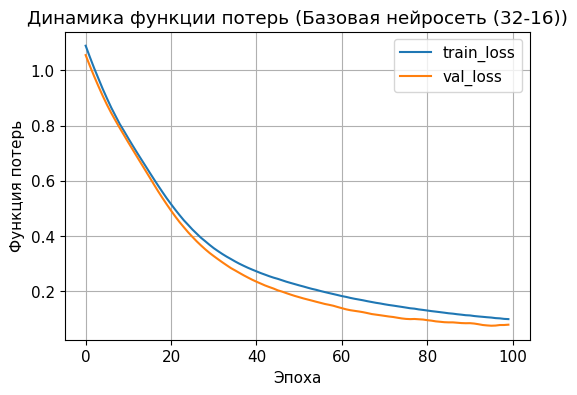

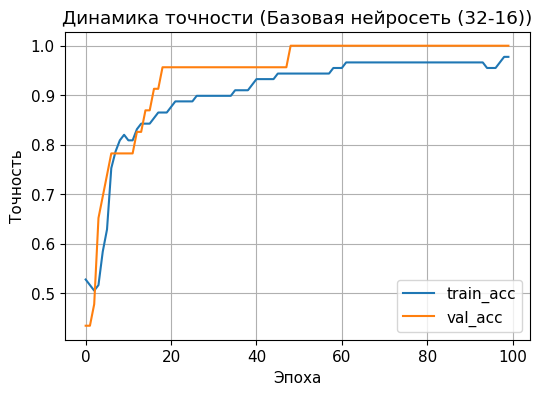

In [13]:
# Блок 13. Базовая нейронная сеть (простая архитектура)

# Разделяем обучающую выборку на обучение и валидацию
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_nn,
    y_train_cat,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_train
)

# Базовая модель: два полносвязных слоя средней размерности
model_nn_base = keras.Sequential([
    layers.Input(shape=(X_train_nn.shape[1],)),
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])

model_nn_base.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_nn_base, history_base = train_nn_model(
    model_nn_base,
    X_train_sub, y_train_sub,
    X_val_sub, y_val_sub,
    X_test_nn, y_test_cat,
    y_test,
    name="Базовая нейросеть (32-16)",
    epochs=100,
    batch_size=32
)


Здесь создаётся и обучается базовая архитектура нейронной сети, которая служит отправной точкой для последующего «форсирования» гиперпараметров. Для более честной оценки качества из исходной обучающей выборки выделяется отдельная валидационная подвыборка, на которой контролируется процесс обучения и применяется ранняя остановка. Разделение выполняется стратифицированно, чтобы сохранить пропорции классов.

Архитектура базовой сети представляет собой простую полносвязную модель: входной слой, затем два скрытых слоя на 32 и 16 нейронов с нелинейной функцией активации ReLU и выходной слой с числом нейронов, равным количеству классов, и активацией softmax. Такая структура позволяет модели аппроксимировать нелинейные зависимости между признаками, не будучи при этом чрезмерно сложной и склонной к переобучению.

После компиляции с оптимизатором Adam и функцией потерь `categorical_crossentropy` модель обучается заданное число эпох с использованием механизма ранней остановки. По завершении обучения на тестовой выборке рассчитываются метрики качества и строятся графики динамики обучения. Этот вариант сети можно рассматривать как «обычную» конфигурацию без агрессивного подбора гиперпараметров.

## 12. Форсированная нейросеть номер 1

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step

==================== Форсированная нейросеть №1 (64-32-16, lr=0.0005) ====================
Test loss: 0.2604
Test accuracy: 0.8421
Accuracy (sklearn): 0.8421
Precision (macro): 0.8516
Recall (macro): 0.8440
F1 (macro): 0.8469
ROC-AUC (macro, ovr): 0.9754

Матрица ошибок:
[[11  1  0]
 [ 0 10  3]
 [ 0  2 11]]

Отчёт классификации:
              precision    recall  f1-score   support

      setosa       1.00      0.92      0.96        12
  versicolor       0.77      0.77      0.77        13
   virginica       0.79      0.85      0.81        13

    accuracy                           0.84        38
   macro avg       0.85      0.84      0.85        38
weighted avg       0.85      0.84      0.84        38



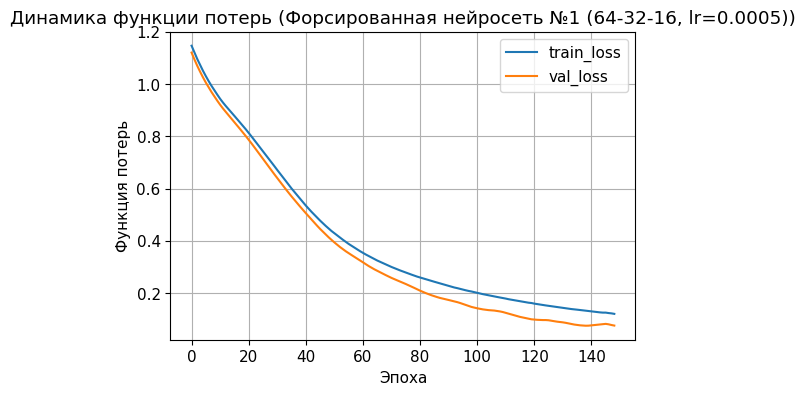

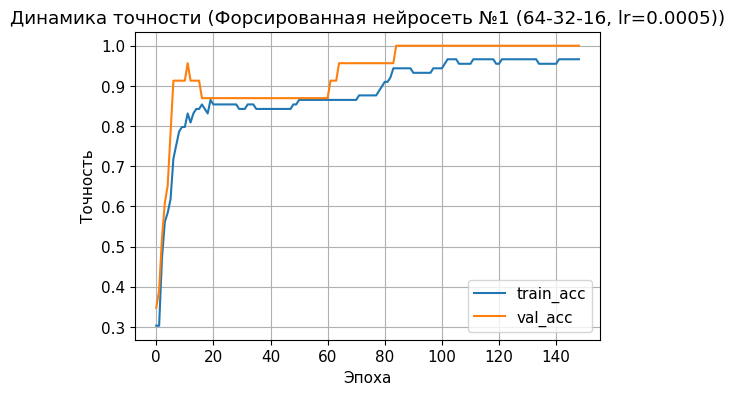

In [14]:
# Блок 14. Форсированная нейросеть №1 (более широкая архитектура)

model_nn_wide = keras.Sequential([
    layers.Input(shape=(X_train_nn.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])

model_nn_wide.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_nn_wide, history_wide = train_nn_model(
    model_nn_wide,
    X_train_sub, y_train_sub,
    X_val_sub, y_val_sub,
    X_test_nn, y_test_cat,
    y_test,
    name="Форсированная нейросеть №1 (64-32-16, lr=0.0005)",
    epochs=150,
    batch_size=64
)


В данном блоке создаётся первая «форсированная» версия нейронной сети, в которой гиперпараметры усилены по сравнению с базовой моделью. Увеличивается как глубина, так и ширина сети: используется три скрытых слоя на 64, 32 и 16 нейронов соответственно. Такая архитектура обладает большей аппроксимационной способностью и способна моделировать более сложные зависимости в данных.

Помимо изменения структуры сети, настраиваются и параметры обучения. В качестве оптимизатора по-прежнему используется Adam, однако скорость обучения (`learning_rate`) уменьшается до 0.0005. Меньший шаг градиентного спуска позволяет аккуратнее подбирать веса, что особенно важно для более глубокой архитектуры. Также увеличивается максимальное число эпох до 150 и размер батча до 64, что даёт модели больше возможностей для сходимости при достаточно стабильном обновлении весов.

Результаты обучения этой форсированной модели сравниваются с базовой: по метрикам на тестовой выборке и по графикам динамики функции потерь и точности. Если форсирование гиперпараметров выполнено удачно, можно ожидать либо улучшения F1-score и ROC-AUC, либо более плавного и устойчивого процесса обучения.

## 13. Форсированная нейронная сеть номер 2

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002942B92EE80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step

==================== Форсированная нейросеть №2 (64-32 + BatchNorm + Dropout) ====================
Test loss: 0.1742
Test accuracy: 0.9211
Accuracy (sklearn): 0.9211
Precision (macro): 0.9246
Reca

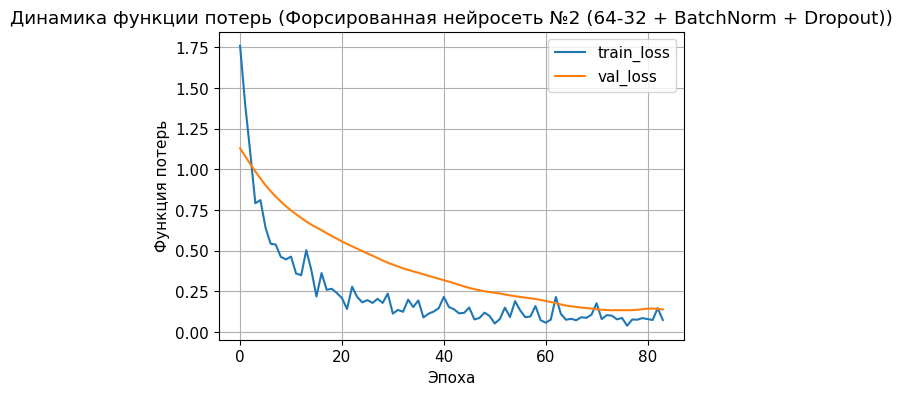

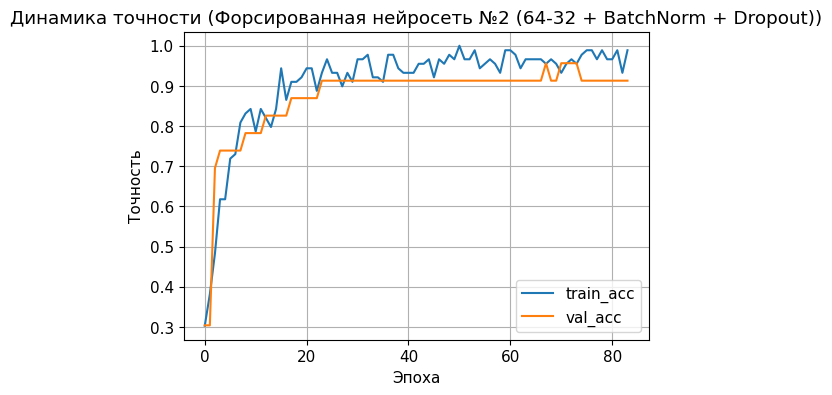

In [15]:
# Блок 15. Форсированная нейросеть №2 (регуляризация Dropout + BatchNormalization)

model_nn_reg = keras.Sequential([
    layers.Input(shape=(X_train_nn.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation="softmax")
])

model_nn_reg.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_nn_reg, history_reg = train_nn_model(
    model_nn_reg,
    X_train_sub, y_train_sub,
    X_val_sub, y_val_sub,
    X_test_nn, y_test_cat,
    y_test,
    name="Форсированная нейросеть №2 (64-32 + BatchNorm + Dropout)",
    epochs=150,
    batch_size=32
)


Во второй форсированной версии нейронной сети основной акцент делается на регуляризации и повышении устойчивости обучения. Архитектура включает два скрытых слоя на 64 и 32 нейрона, между которыми добавляются слои `BatchNormalization` и `Dropout`. Нормализация батчей стабилизирует распределение активаций и позволяет ускорить обучение, а Dropout с вероятностью зануления 0.3 отключает случайные нейроны в процессе обучения, уменьшая риск переобучения.

Такая комбинация слоёв делает модель более устойчивой к шуму в данных и предотвращает «запоминание» отдельных объектов обучающей выборки. В качестве оптимизатора снова используется Adam со стандартной скоростью обучения 0.001, а число эпох и размер батча подобраны так, чтобы модель успевала как достаточно обучиться, так и не переобучиться благодаря регуляризации и ранней остановке.

Сравнение метрик этой модели с базовой и первой форсированной версией позволяет оценить влияние регуляризации и нормализации на итоговое качество классификации. В идеале модель с Dropout и BatchNormalization должна показывать более устойчивые результаты на тестовой выборке и сглаженные графики функции потерь и точности.

## 14. Сводная таблица метрик нейронных сетей

In [16]:
# Блок 16. Сводная таблица метрик нейронных сетей

nn_metrics_df = pd.DataFrame(nn_metrics)
print("Метрики нейронных сетей на датасете ирисов:")
display(nn_metrics_df)

print("\nНейросети, отсортированные по F1-macro:")
display(nn_metrics_df.sort_values(by="f1_macro", ascending=False))


Метрики нейронных сетей на датасете ирисов:


,model,accuracy,precision_macro,recall_macro,f1_macro,roc_auc_macro
0,Базовая нейросеть (32-16),0.947368,0.950549,0.946581,0.947521,0.990769
1,"Форсированная нейросеть №1 (64-32-16, lr=0.0005)",0.842105,0.851648,0.844017,0.846856,0.975385
2,Форсированная нейросеть №2 (64-32 + BatchNorm ...,0.921053,0.924603,0.923077,0.922963,0.993846



Нейросети, отсортированные по F1-macro:


,model,accuracy,precision_macro,recall_macro,f1_macro,roc_auc_macro
0,Базовая нейросеть (32-16),0.947368,0.950549,0.946581,0.947521,0.990769
2,Форсированная нейросеть №2 (64-32 + BatchNorm ...,0.921053,0.924603,0.923077,0.922963,0.993846
1,"Форсированная нейросеть №1 (64-32-16, lr=0.0005)",0.842105,0.851648,0.844017,0.846856,0.975385


Завершающий блок по нейронным сетям собирает все накопленные метрики в таблицу `nn_metrics_df`. В этой таблице для каждой архитектуры указаны значения Accuracy, макро-усреднённых Precision, Recall, F1-score и ROC-AUC. Это позволяет напрямую сравнить базовую нейросеть и обе форсированные версии, оценив, насколько изменение архитектуры и гиперпараметров повлияло на качество классификации.

Сортировка таблицы по F1-macro даёт наглядный ответ на вопрос, какая из рассмотренных нейросетей обеспечивает наилучший баланс между точностью и полнотой по всем классам классификации ирисов. Если форсированные модели действительно оказались лучше, это будет видно по росту F1-score и, как правило, по увеличению ROC-AUC. В противном случае можно сделать вывод, что усложнение архитектуры или изменение параметров обучения не привели к существенному улучшению и базовая модель уже даёт близкий к оптимальному результат.

Таким образом, данный блок завершает сравнительный анализ нейросетевых моделей и дополняет картину, полученную при исследовании классических алгоритмов классификации. В совокупности это позволяет осознанно выбирать как тип модели, так и её внутренние параметры для решения задачи оценки классификации ирисов.

## 15. Форсированная нейросеть номер 3

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step

==================== Форсированная нейросеть №3 (32-16, L2=0.001) ====================
Test loss: 0.2025
Test accuracy: 0.8947
Accuracy (sklearn): 0.8947
Precision (macro): 0.9056
Recall (macro): 0.8953
F1 (macro): 0.8979
ROC-AUC (macro, ovr): 0.9949

Матрица ошибок:
[[11  1  0]
 [ 0 12  1]
 [ 0  2 11]]

Отчёт классификации:
              precision    recall  f1-score   support

      setosa       1.00      0.92      0.96        12
  versicolor       0.80      0.92      0.86        13
   virginica       0.92      0.85      0.88        13

    accuracy                           0.89        38
   macro avg       0.91      0.90      0.90        38
weighted avg       0.90      0.89      0.90        38



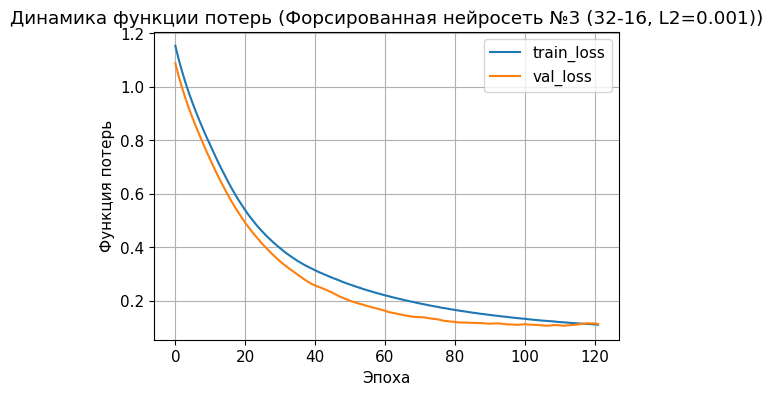

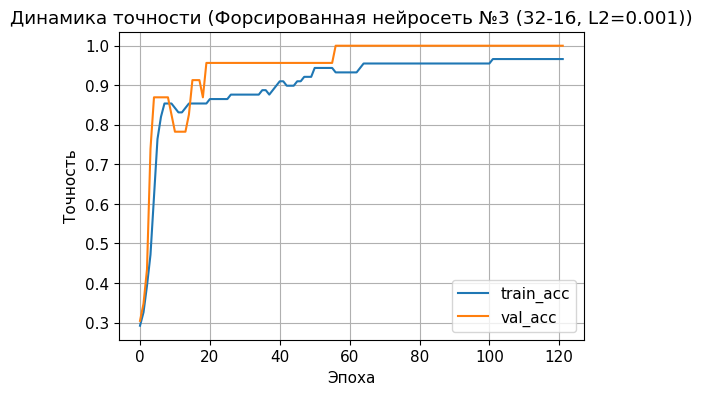

In [17]:
# Блок 17. Форсированная нейросеть №3 (меньшая модель с L2-регуляризацией)

from tensorflow.keras import regularizers

model_nn_l2 = keras.Sequential([
    layers.Input(shape=(X_train_nn.shape[1],)),
    layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(16, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(n_classes, activation="softmax")
])

model_nn_l2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_nn_l2, history_l2 = train_nn_model(
    model_nn_l2,
    X_train_sub, y_train_sub,
    X_val_sub, y_val_sub,
    X_test_nn, y_test_cat,
    y_test,
    name="Форсированная нейросеть №3 (32-16, L2=0.001)",
    epochs=150,
    batch_size=32
)


В этом блоке добавляется четвёртая нейронная сеть, отличающаяся от предыдущих акцентом на L2-регуляризацию весов. Архитектура модели намеренно сделана более компактной: два скрытых слоя на 32 и 16 нейронов с функцией активации ReLU. К каждому слою применяется регуляризатор `kernel_regularizer=regularizers.l2(0.001)`, который штрафует слишком большие значения весов и тем самым препятствует переобучению.

В отличие от варианта с Dropout, где «выключаются» целые нейроны, L2-регуляризация делает обучение более «аккуратным», постепенно поджимая веса к нулю. Такая стратегия особенно полезна, когда количество признаков относительно невелико, а модель имеет тенденцию подстраиваться под шум. Остальные параметры обучения остаются близкими к стандартным: оптимизатор Adam со скоростью 0.001, умеренное количество эпох и размер батча 32.

Сравнение этой модели с базовой и другими форсированными нейросетями позволяет оценить, насколько эффективно L2-регуляризация помогает улучшить обобщающую способность модели и стабилизировать метрики качества на тестовой выборке. Дополнительные отдельные графики функции потерь и точности по эпохам наглядно показывают влияние регуляризатора на процесс обучения.